In [2]:
import os
import numpy as np
import cv2
import transformations
import scipy.io as sio
import glob
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import sys
import data_generation
import networks
import param
import util
import truncated_vgg
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
vid_info_list = data_generation.make_vid_info_list('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test')

In [4]:
vid_info_list[0][1]

array([[ 687.64548803,  125.95119705,  205.08287293,  433.73848987],
       [ 652.28637201,  118.87937385,  169.72375691,  497.38489871],
       [ 635.7854512 ,  130.66574586,  169.72375691,  469.09760589],
       [ 621.64180479,  140.09484346,  150.86556169,  438.45303867],
       [ 673.50184162,  142.45211786,  106.07734807,  424.30939227],
       [ 623.99907919,  128.30847145,  124.93554328,  445.52486188],
       [ 697.07458564,  125.95119705,  157.9373849 ,  464.38305709],
       [ 657.00092081,  137.73756906,  132.00736648,  447.88213628]])

In [5]:
img_01 = Image.open('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test/frames/Golf Lessons - Stop Topping Fairway Woods/1.png')

In [6]:
img_01 = np.array(img_01, dtype=np.uint8)

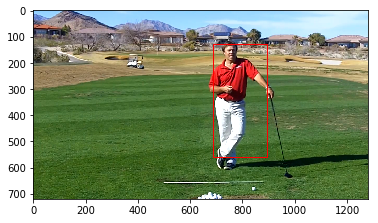

In [7]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((687.64548803,125.95119705),205.08287293,433.73848987,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [8]:
len(vid_info_list[0][2])

14

In [9]:
vid_info_list[0][2][3]

array([[ 687.64548803,  652.28637201,  659.35819521,  659.35819521,
         697.07458564,  652.28637201,  744.22007366,  657.00092081],
       [ 290.96040516,  290.96040516,  288.60313076,  302.74677716,
         314.53314917,  290.96040516,  290.96040516,  326.31952118]])

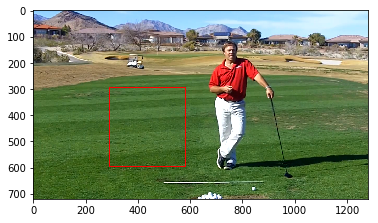

In [10]:
# Create figure and axes
fig1,ax1 = plt.subplots(1)

# Display the image
ax1.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((290.96040516,  290.96040516),  288.60313076,  302.74677716,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)

plt.show()

In [11]:
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

# 2. choose pair of frames
n_frames = vid_x.shape[2]
frames = np.random.choice(n_frames, 2, replace=False)
while abs(frames[0] - frames[1]) / (n_frames * 1.0) <= 0.02:
    frames = np.random.choice(n_frames, 2, replace=False)

In [13]:
n_frames

8

In [15]:
frames

array([5, 2])

In [16]:

joints = vid_x[:, :, 0] - 1.0
box_frame = vid_bbox[0, :]
scale = data_generation.get_person_scale(joints)
pos = np.zeros(2)
pos[0] = (box_frame[0] + box_frame[2] / 2.0)
pos[1] = (box_frame[1] + box_frame[3] / 2.0)

In [31]:
joints

array([[ 750.29189687,  124.95119705],
       [ 755.00644567,  202.7412523 ],
       [ 705.50368324,  238.10036832],
       [ 686.64548803,  289.96040516],
       [ 724.36187845,  301.74677716],
       [ 806.8664825 ,  209.81307551],
       [ 856.36924494,  252.24401473],
       [ 891.72836096,  297.03222836],
       [ 722.00460405,  348.89226519],
       [ 731.43370166,  464.39871087],
       [ 747.93462247,  558.68968692],
       [ 785.65101289,  360.6786372 ],
       [ 785.65101289,  473.82780847],
       [ 719.64732965,  546.90331492]])

In [37]:
box_frame

array([ 687.64548803,  125.95119705,  205.08287293,  433.73848987])

In [34]:
data = np.array(joints)
x, y = data.T
plt.scatter(x,y)

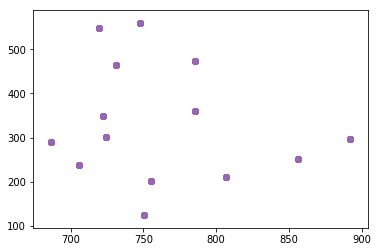

In [35]:
plt.show()

In [38]:
scale

2.8729281767955799